In [1]:
import os.path as osp
import torch
from torch.utils.data import Dataset, TensorDataset
from torch.nn import ConstantPad2d
import torch.nn.functional as F
import itertools
import numpy as np
import uproot
import glob
import multiprocessing
from pathlib import Path
import yaml
from tqdm.notebook import tqdm
import awkward as ak
import vector
from sklearn import preprocessing, metrics
from sklearn.isotonic import IsotonicRegression

import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = 'cpu'
print(DEVICE)

cuda:0


In [2]:
jet_feature = "jet_4vec"
electron_feature = "electron_4vec"

In [3]:
#features = jet_features + electron_features #+ muon_features

In [4]:
#weight_features = ["weight_mc", "weight_pileup", "weight_leptonSF", "weight_jvt", "weight_bTagSF_DL1r_Continuous"]
weight_features = ["genWeight", "btagWeight_CSVV2"]

In [5]:
# Luminosities in pb^-1
luminosities = {'2015': 36207.66, '2017': 44307.4, '2018': 58450.1}
luminosities_by_run = {'9364': 36207.66, '10201': 44307.4, '10724': 58450.1}

## Define how to load a dataset and prepare it for training

In [6]:
class DeepSetsDataset:
    def __init__(
        self,
        file_names,
        feature,
        label,
        weights="weight_mc_combined",
        start_event=0,
        stop_event=1000,
        npad=0,
    ):
        """
        Initialize parameters of Deep Sets dataset
        Args:
            root (str): path
            n_events (int): how many events to process (-1=all)
            n_events_merge (int): how many events to merge
            file_names (list of strings): file names
            remove_unlabeled (boolean): remove unlabeled data samples
        """
        self.feature = feature
        self.label = label
        self.weights = weights
        self.n_events = stop_event - start_event
        self.start_event = start_event
        self.stop_event = stop_event
        self.file_names = file_names
        self.npad = npad
        self.datas = []


    def process(self):
        """
        Handles conversion of dataset file at raw_path into Deep Sets dataset.

        """
        self.datas = []
        for raw_path in self.file_names:
            with uproot.open(raw_path) as root_file:

                tree = root_file["Events"]

                feature_array = tree.arrays(
                    self.feature,
                    entry_start=self.start_event,
                    entry_stop=self.stop_event,
                    library="ak",
                )

                weight_array = tree.arrays(
                    self.weights,
                    entry_start=self.start_event,
                    entry_stop=self.stop_event,
                    library='ak',
                )

            if self.label == 0:
                y = np.zeros((self.n_events, 1))
            elif self.label == 1:
                y = np.ones((self.n_events, 1))

            for i in tqdm(range(self.n_events)):
                # Each event is a flattened array with entries [feat1, feat2, feat3, ..., featn] * n_particles
                # 'x' is a 2D tensor with shape (M,N) where N is the number of features and M is the number of particles
                x = torch.from_numpy(feature_array[self.feature][i].to_numpy().astype(np.float32).reshape(-1, 4))
                # Uncomment the following lines if you want a fixed input size, i.e. padding/cutting
                #if x.size(dim=1) < self.npad:
                #    x = ConstantPad2d((0, self.npad - x.size(dim=1), 0, 0), 0.0)(x)
                #else:
                #    x = x[:, : self.npad]
                x = x[None, :]
                Y = torch.tensor(y[i : i + 1], dtype=torch.float)
                w = torch.tensor([[weight_array[self.weights][i]]], dtype=torch.float)
                data = TensorDataset(x, Y, w)
                self.datas.append(data)

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.datas[idx]

## Initiate the datasets

In [7]:
n_train_events = int(400000) // 2
n_val_events = int(1e5) // 2
n_test_events = int(1e5)

train_nominal_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_nominal_DeepSets_training_data.root",], jet_feature, 0, stop_event=n_train_events)
valid_nominal_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_nominal_DeepSets_validation_data.root",], jet_feature, 0, stop_event=n_val_events)
calibration_nominal_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_nominal_DeepSets_validation_data.root",], jet_feature, 0, start_event=n_val_events, stop_event=2*n_val_events)
test_nominal_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_nominal_DeepSets_testing_data.root",], jet_feature, 0, stop_event=n_test_events)

train_PS_var_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_PS_var_DeepSets_training_data.root",], jet_feature, 1, stop_event=n_train_events)
valid_PS_var_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_PS_var_DeepSets_validation_data.root",], jet_feature, 1, stop_event=n_val_events)
calibration_PS_var_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_PS_var_DeepSets_validation_data.root",], jet_feature, 1, start_event=n_val_events, stop_event=2*n_val_events)
test_PS_var_dataset = DeepSetsDataset(["/data/mdrnevich/AGC/CMS_ttbar_PS_var_DeepSets_testing_data.root",], jet_feature, 1, stop_event=n_test_events)

## Load the data

In [8]:
train_nominal_dataset.process()
valid_nominal_dataset.process()
calibration_nominal_dataset.process()
test_nominal_dataset.process()

train_PS_var_dataset.process()
valid_PS_var_dataset.process()
calibration_PS_var_dataset.process()
test_PS_var_dataset.process()

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

## Prepare the data for scaling

In [9]:
from torch.utils.data import ConcatDataset

train_generator_data = ConcatDataset(train_nominal_dataset.datas + train_PS_var_dataset.datas)
valid_generator_data = ConcatDataset(valid_nominal_dataset.datas + valid_PS_var_dataset.datas)
calibration_generator_data = ConcatDataset(calibration_nominal_dataset.datas + calibration_PS_var_dataset.datas)
test_generator_data = ConcatDataset(test_nominal_dataset.datas + test_PS_var_dataset.datas)

In [10]:
from torch.utils.data import random_split, DataLoader

torch.manual_seed(0)
batch_size = 1024

def prep_inputs_for_scaling(batch_list):
    x_batch_list = []
    w_batch_list = []
    for s in batch_list:
        x_batch_list.append(s[0])
        w_batch_list.append(s[2])
    x_batch = torch.cat(x_batch_list, dim=0)
    w_batch = torch.cat(w_batch_list)
    return x_batch, w_batch

scaling_loader = DataLoader(train_generator_data, batch_size=batch_size, shuffle=True)
scaling_loader.collate_fn = prep_inputs_for_scaling

## Do some data preprocessing for standardized inputs and weights

In [11]:
X_scaler = preprocessing.StandardScaler()
weight_total = 0
num_total_weights = 0

for batch in scaling_loader:
    X_scaler.partial_fit(batch[0])
    weight_total += batch[1].sum()
    num_total_weights += len(batch[1])
weight_norm = weight_total / num_total_weights
print(weight_norm)

tensor(3741.1206)


## Prepare the data for training

In [12]:
from torch.utils.data import random_split, DataLoader

torch.manual_seed(0)
batch_size = 1024


def prep_inputs_for_training(batch_list):
    sample_indices = [0]
    x_batch_list = []
    y_batch_list = []
    w_batch_list = []
    for sample in batch_list:
        x_batch_list.append(sample[0])
        y_batch_list.append(sample[1])
        w_batch_list.append(sample[2])
        sample_indices.append(sample[0].size(dim=0))
    x_batch = torch.cat(x_batch_list, dim=0)
    x_batch = torch.from_numpy(X_scaler.transform(x_batch).astype(np.float32).T) # Model expects rows to be features
    y_batch = torch.cat(y_batch_list, dim=0)
    w_batch = torch.cat(w_batch_list, dim=0) / weight_norm
    sample_indices = torch.from_numpy(np.cumsum(sample_indices))
    return (x_batch[None, :], y_batch[:, None], w_batch[:, None]), sample_indices


train_loader = DataLoader(train_generator_data, batch_size=batch_size, shuffle=True) # DEBUGGING --- CHANGE SHUFFLE TO TRUE IN PRACTICE
train_loader.collate_fn = prep_inputs_for_training
valid_loader = DataLoader(valid_generator_data, batch_size=batch_size, shuffle=False)
valid_loader.collate_fn = prep_inputs_for_training

#train_samples = len(train_nominal_dataset) + len(train_PS_var_dataset)
#valid_samples = len(valid_nominal_dataset) + len(valid_PS_var_dataset)

## Construct the model

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import (
    Sequential as Seq,
    Linear as Lin,
    ReLU,
    BatchNorm1d,
    AvgPool1d,
    Sigmoid,
    Conv1d,
)

# ntracks = 60
inputs = 4
hidden1 = 512
hidden2 = 256
hidden3 = 128
classify1 = 256
outputs = 1


class DeepSets(torch.nn.Module):
    def __init__(self):
        super(DeepSets, self).__init__()
        self.phi = Seq(
            Conv1d(inputs, hidden1, 1),
            #BatchNorm1d(hidden1),
            ReLU(),
            Conv1d(hidden1, hidden2, 1),
            #BatchNorm1d(hidden2),
            ReLU(),
            Conv1d(hidden2, hidden3, 1),
            #BatchNorm1d(hidden3),
            ReLU(),
        )
        self.rho = Seq(
            Lin(hidden3, classify1),
            BatchNorm1d(classify1),
            ReLU(),
            Lin(classify1, outputs),
            Sigmoid(),
        )
        

    def forward(self, x, sample_indices):
        out = self.phi(x)
        out = torch.cat([torch.mean(out[:, :, sample_indices[j]:sample_indices[j+1]], dim=2) for j in range(len(sample_indices)-1)], dim=0)
        return self.rho(out)


model = DeepSets()
print(model)
print("----------")
print({l: model.state_dict()[l].shape for l in model.state_dict()})

model = DeepSets().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

DeepSets(
  (phi): Sequential(
    (0): Conv1d(4, 512, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (5): ReLU()
  )
  (rho): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
----------
{'phi.0.weight': torch.Size([512, 4, 1]), 'phi.0.bias': torch.Size([512]), 'phi.2.weight': torch.Size([256, 512, 1]), 'phi.2.bias': torch.Size([256]), 'phi.4.weight': torch.Size([128, 256, 1]), 'phi.4.bias': torch.Size([128]), 'rho.0.weight': torch.Size([256, 128]), 'rho.0.bias': torch.Size([256]), 'rho.1.weight': torch.Size([256]), 'rho.1.bias': torch.Size([256]), 'rho.1.running_mean': torch.Size([256]), 'rho.1.running_var': torch.Size([256]), 'rho.1.num_bat

## Define training and testing loops

In [14]:
@torch.no_grad()
def test(model, loader, leave=False):
    model.eval()

    #xentropy = nn.BCELoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=len(loader), leave=leave)
    for i, batch in t:
        data = batch[0]
        sample_indices = batch[1]
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)
        w = data[2].to(DEVICE)
        sample_indices.to(DEVICE)
        batch_output = model(x, sample_indices)
        batch_loss_item = F.binary_cross_entropy(batch_output, y, weight=w).cpu().item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh()  # to show immediately the update

    return sum_loss / (i + 1)


def train(model, optimizer, loader, leave=False):
    model.train()

    #xentropy = nn.BCELoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=len(loader), leave=leave)
    for i, batch in t:
        data = batch[0]
        sample_indices = batch[1]
        optimizer.zero_grad()
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)
        w = data[2].to(DEVICE)
        sample_indices.to(DEVICE)
        #print(x.size(), sample_indices)
        batch_output = model(x, sample_indices)
        batch_loss = F.binary_cross_entropy(batch_output, y, weight=w)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh()  # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()

    return sum_loss / (i + 1)

## Perform the training

In [16]:
import os.path as osp

n_epochs = 30
stale_epochs = 0
best_valid_loss = 99999
patience = 6
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(
        model,
        optimizer,
        train_loader,
        leave=bool(epoch == n_epochs - 1),
    )
    valid_loss = test(
        model,
        valid_loader,
        leave=bool(epoch == n_epochs - 1),
    )
    print("Epoch: {:02d}, Training Loss:   {:.4f}".format(epoch, loss))
    print("           Validation Loss: {:.4f}".format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join("deepsets_best.pth")
        print("New best model saved to:", modpath)
        torch.save(model.state_dict(), modpath)
        stale_epochs = 0
    else:
        print("Stale epoch")
        stale_epochs += 1
    if stale_epochs >= patience:
        print("Early stopping after %i stale epochs" % patience)
        break

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.6894
           Validation Loss: 0.6874
New best model saved to: deepsets_best.pth


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.6855
           Validation Loss: 0.6853
New best model saved to: deepsets_best.pth


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   0.6840
           Validation Loss: 0.6840
New best model saved to: deepsets_best.pth


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   0.6833
           Validation Loss: 0.6825
New best model saved to: deepsets_best.pth


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   0.6831
           Validation Loss: 0.6831
Stale epoch


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   0.6830
           Validation Loss: 0.6839
Stale epoch


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   0.6830
           Validation Loss: 0.6836
Stale epoch


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   0.6829
           Validation Loss: 0.6830
Stale epoch


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   0.6827
           Validation Loss: 0.6840
Stale epoch


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 09, Training Loss:   0.6826
           Validation Loss: 0.6832
Stale epoch
Early stopping after 6 stale epochs


# Evaluate the effectiveness of this model on test data

## Load the best model

In [15]:
model.load_state_dict(torch.load(osp.join("deepsets_best.pth")))
print(model)
print("----------")
print({l: model.state_dict()[l].shape for l in model.state_dict()})

DeepSets(
  (phi): Sequential(
    (0): Conv1d(4, 512, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (5): ReLU()
  )
  (rho): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
----------
{'phi.0.weight': torch.Size([512, 4, 1]), 'phi.0.bias': torch.Size([512]), 'phi.2.weight': torch.Size([256, 512, 1]), 'phi.2.bias': torch.Size([256]), 'phi.4.weight': torch.Size([128, 256, 1]), 'phi.4.bias': torch.Size([128]), 'rho.0.weight': torch.Size([256, 128]), 'rho.0.bias': torch.Size([256]), 'rho.1.weight': torch.Size([256]), 'rho.1.bias': torch.Size([256]), 'rho.1.running_mean': torch.Size([256]), 'rho.1.running_var': torch.Size([256]), 'rho.1.num_bat

## Prepare the test data

In [16]:
calibration_loader = DataLoader(calibration_generator_data, batch_size=batch_size, shuffle=True)
calibration_loader.collate_fn = prep_inputs_for_training

test_loader = DataLoader(test_generator_data, batch_size=batch_size, shuffle=False)
test_loader.collate_fn = prep_inputs_for_training

test_nominal_loader = DataLoader(ConcatDataset(test_nominal_dataset.datas), batch_size=batch_size, shuffle=False)
test_nominal_loader.collate_fn = prep_inputs_for_training

## Get the scores (model output) on the test data

In [17]:
@torch.no_grad()
def get_scores(model, loader, leave=False):
    model.eval()

    score_list = []
    target_list = []
    weight_list = []
    t = tqdm(enumerate(loader), total=len(loader), leave=leave)
    for i, batch in t:
        data = batch[0]
        target_list.append(data[1])
        weight_list.append(data[2])
        sample_indices = batch[1]
        x = data[0].to(DEVICE)
        sample_indices.to(DEVICE)
        batch_score = model(x, sample_indices)
        score_list.append(batch_score)
        t.refresh()  # to show immediately the update

    return torch.cat(score_list).cpu().numpy().flatten(), torch.cat(target_list).cpu().numpy().flatten(), torch.cat(weight_list).cpu().numpy().flatten()

In [18]:
test_scores, test_targets, test_weights = get_scores(
    model,
    test_loader
)

  0%|          | 0/196 [00:00<?, ?it/s]

## Evaluate the ROC curve for the model

In [19]:
print("Area under the ROC curve: {:.4}".format(metrics.roc_auc_score(test_targets, test_scores, sample_weight=test_weights)))

Area under the ROC curve: 0.582


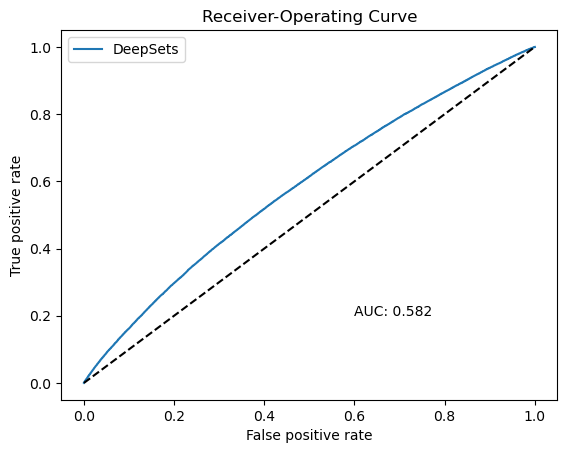

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(test_targets, test_scores, pos_label=1, sample_weight=test_weights)

plt.plot(fpr, tpr, label="DeepSets")
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), '--', c="black")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver-Operating Curve")
plt.legend()
plt.text(0.6, 0.2, "AUC: {:.4}".format(metrics.roc_auc_score(test_targets, test_scores, sample_weight=test_weights)));

## Calibrate the model

In [21]:
iso = IsotonicRegression()
iso.fit(*get_scores(
    model,
    calibration_loader
))

  0%|          | 0/98 [00:00<?, ?it/s]

IsotonicRegression()

## Get the CARL weights

In [22]:
@torch.no_grad()
def get_r_hats(model, loader, leave=False):
    model.eval()

    r_hat_list = []
    t = tqdm(enumerate(loader), total=len(loader), leave=leave)
    for i, batch in t:
        data = batch[0]
        sample_indices = batch[1]
        x = data[0].to(DEVICE)
        sample_indices.to(DEVICE)
        batch_output = model(x, sample_indices)
        r_hat = batch_output / (1 - batch_output)
        r_hat_list.append(r_hat)
        t.refresh()  # to show immediately the update

    return torch.cat(r_hat_list).cpu().numpy().flatten()

In [24]:
r_hats = get_r_hats(
            model,
            test_nominal_loader
)

  0%|          | 0/98 [00:00<?, ?it/s]

## Try calibrated weights also

In [ ]:
def get_calibrated_r_hats(model, calib_fn, loader, leave=False):
    model.eval()

    r_hat_list = []
    t = tqdm(enumerate(loader), total=len(loader), leave=leave)
    for i, batch in t:
        data = batch[0]
        sample_indices = batch[1]
        x = data[0].to(DEVICE)
        sample_indices.to(DEVICE)
        batch_output = calib_fn(model(x, sample_indices).cpu().detach().numpy())
        r_hat = batch_output / (1 - batch_output)
        r_hat_list.append(r_hat)
        t.refresh()  # to show immediately the update

    return np.concatenate(r_hat_list).flatten()

In [25]:
calibrated_r_hats = get_calibrated_r_hats(
            model,
            iso.predict,
            test_nominal_loader
)

  0%|          | 0/98 [00:00<?, ?it/s]

## Get the data for plotting

In [26]:
def jet_pT(batch_list, ix):
    x_batch_list = []
    w_batch_list = []
    for sample in batch_list:
        t = sample[0]
        t = t[t[:,0].argsort(dim=0, descending=True)]
        try:
            x_batch_list.append(t[ix, 0])
        except IndexError:
            x_batch_list.append(np.nan)
        w_batch_list.append(sample[2])
    x_batch = torch.tensor(x_batch_list)
    w_batch = torch.cat(w_batch_list, dim=0)
    return x_batch[:, None], w_batch[:, None]
    

In [27]:
def event_mass(batch_list):
    x_batch_list = []
    w_batch_list = []
    for sample in batch_list:
        _data = sample[0].numpy()
        vec = vector.array(
            {
                "pt": _data[:,0],
                "eta": _data[:,1],
                "phi": _data[:,2],
                "M": _data[:,3]
            }
        )
        total_vec = vec[0]
        for v in vec[1:]:
            total_vec += v
        x_batch_list.append(total_vec.mass)
        w_batch_list.append(sample[2])
    x_batch = torch.tensor(x_batch_list)
    w_batch = torch.cat(w_batch_list, dim=0)
    return x_batch[:, None], w_batch[:, None]

In [28]:
test_nominal_jet_pT_loader = DataLoader(ConcatDataset(test_nominal_dataset.datas), batch_size=batch_size, shuffle=False)
test_PS_var_jet_pT_loader = DataLoader(ConcatDataset(test_PS_var_dataset.datas), batch_size=batch_size, shuffle=False)

#test_nominal_jet_pT_loader.collate_fn = event_mass
#test_PS_var_jet_pT_loader.collate_fn = event_mass

In [29]:
@torch.no_grad()
def get_plot_data(loader):
    temp_x = []
    temp_w = []
    t = tqdm(enumerate(loader), total=len(loader))
    for i, batch in t:
        temp_x.append(batch[0])
        temp_w.append(batch[1])
        t.refresh()  # to show immediately the update
    return torch.cat(temp_x).numpy().flatten(), torch.cat(temp_w).numpy().flatten()

## Plot the reweighted distributions

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

100000
100000


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

99995
99997


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

99891
99906


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

98961
99252


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

94927
96278


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

84921
88477


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

69114
74867


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

50951
57672


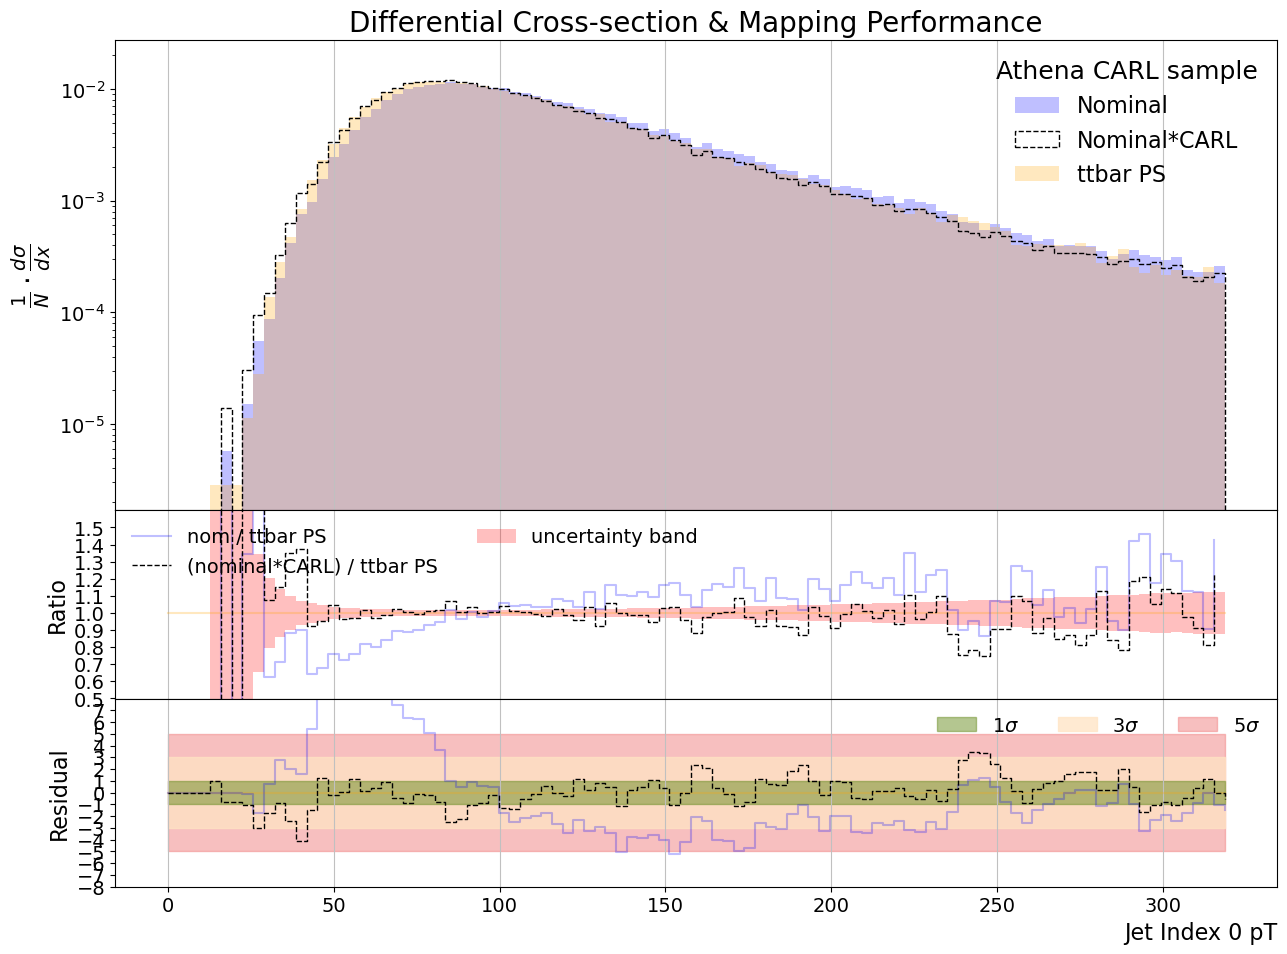

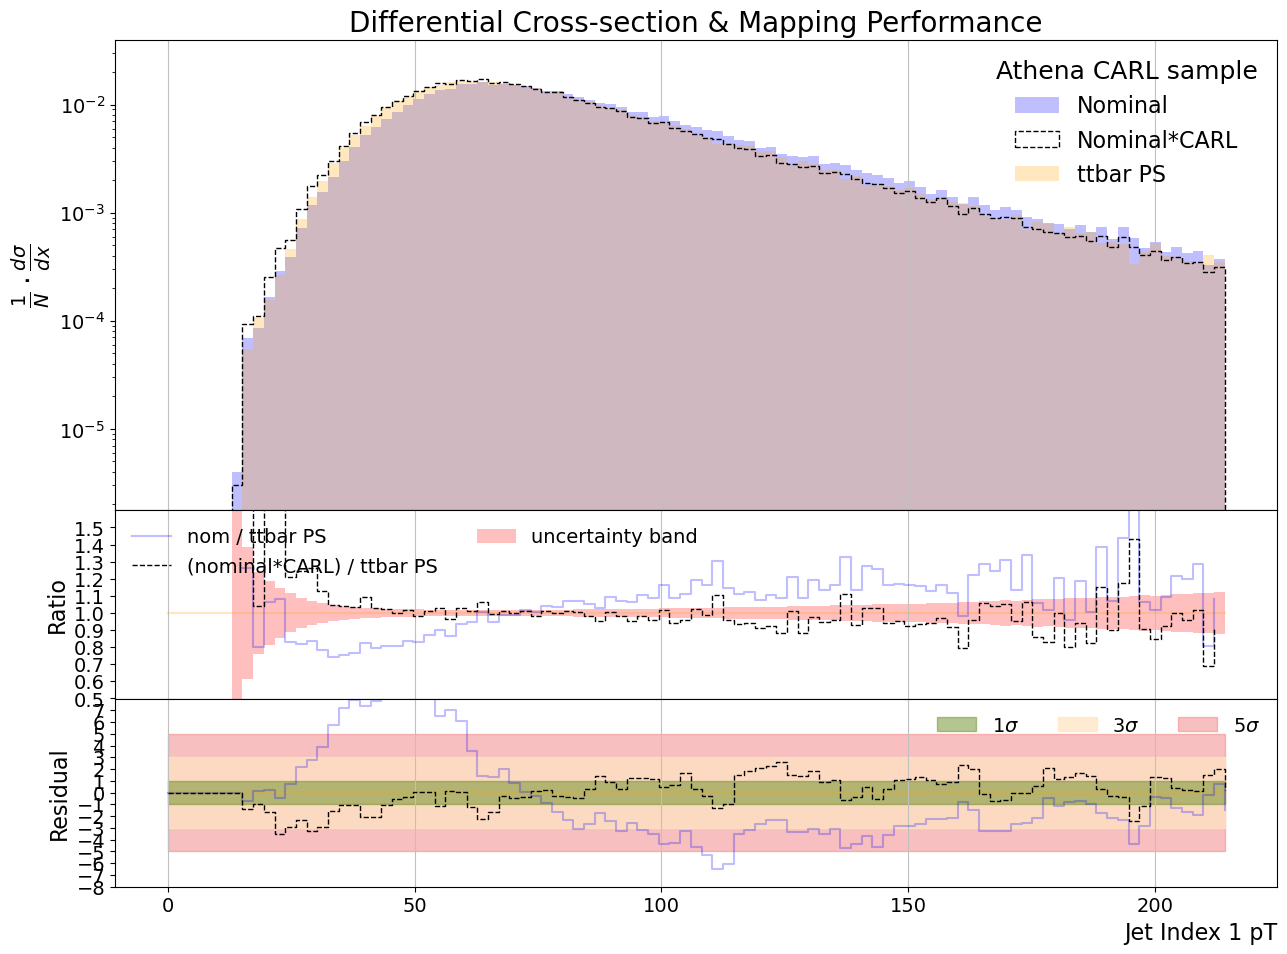

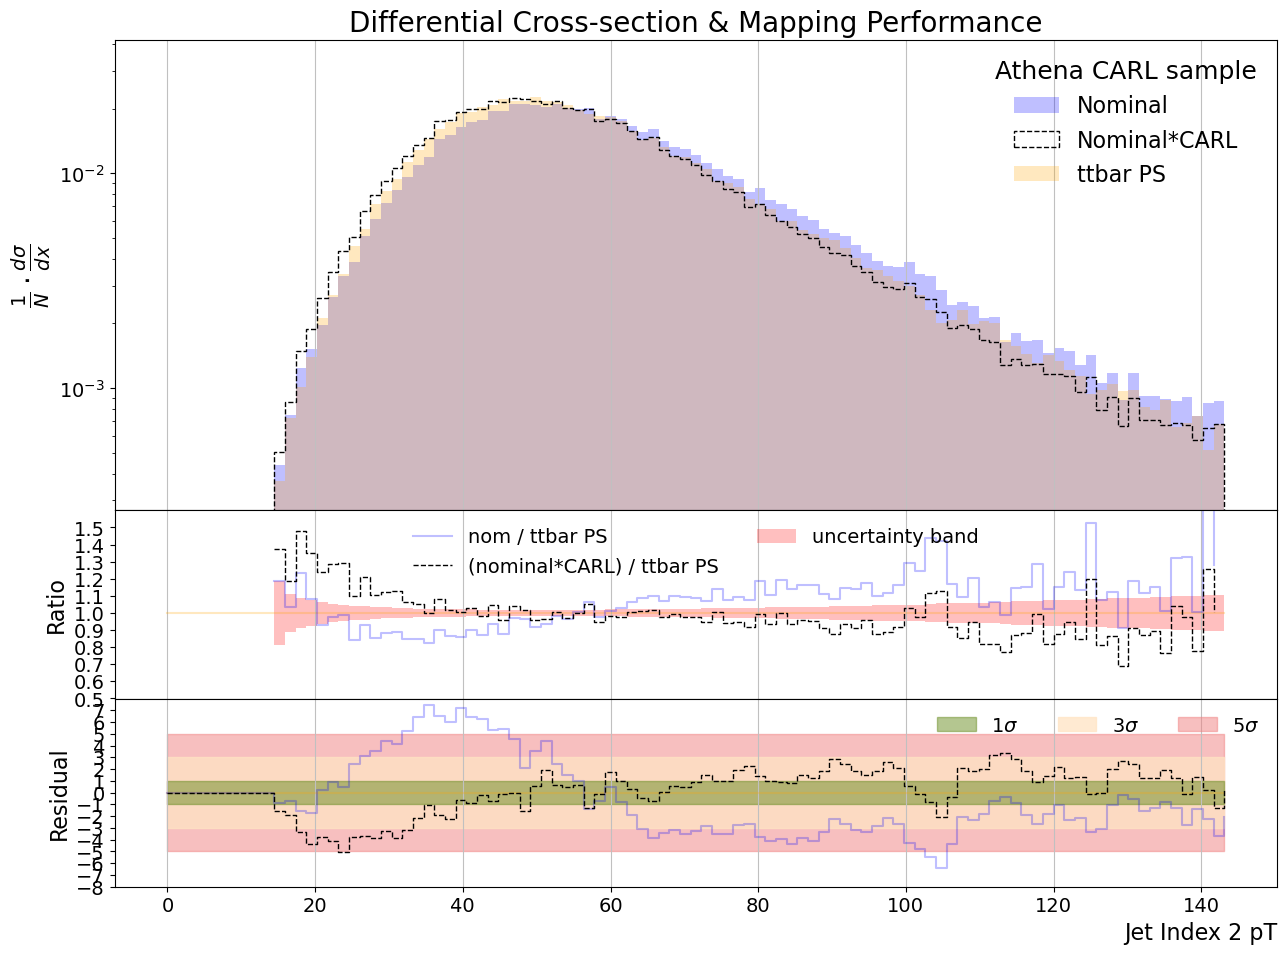

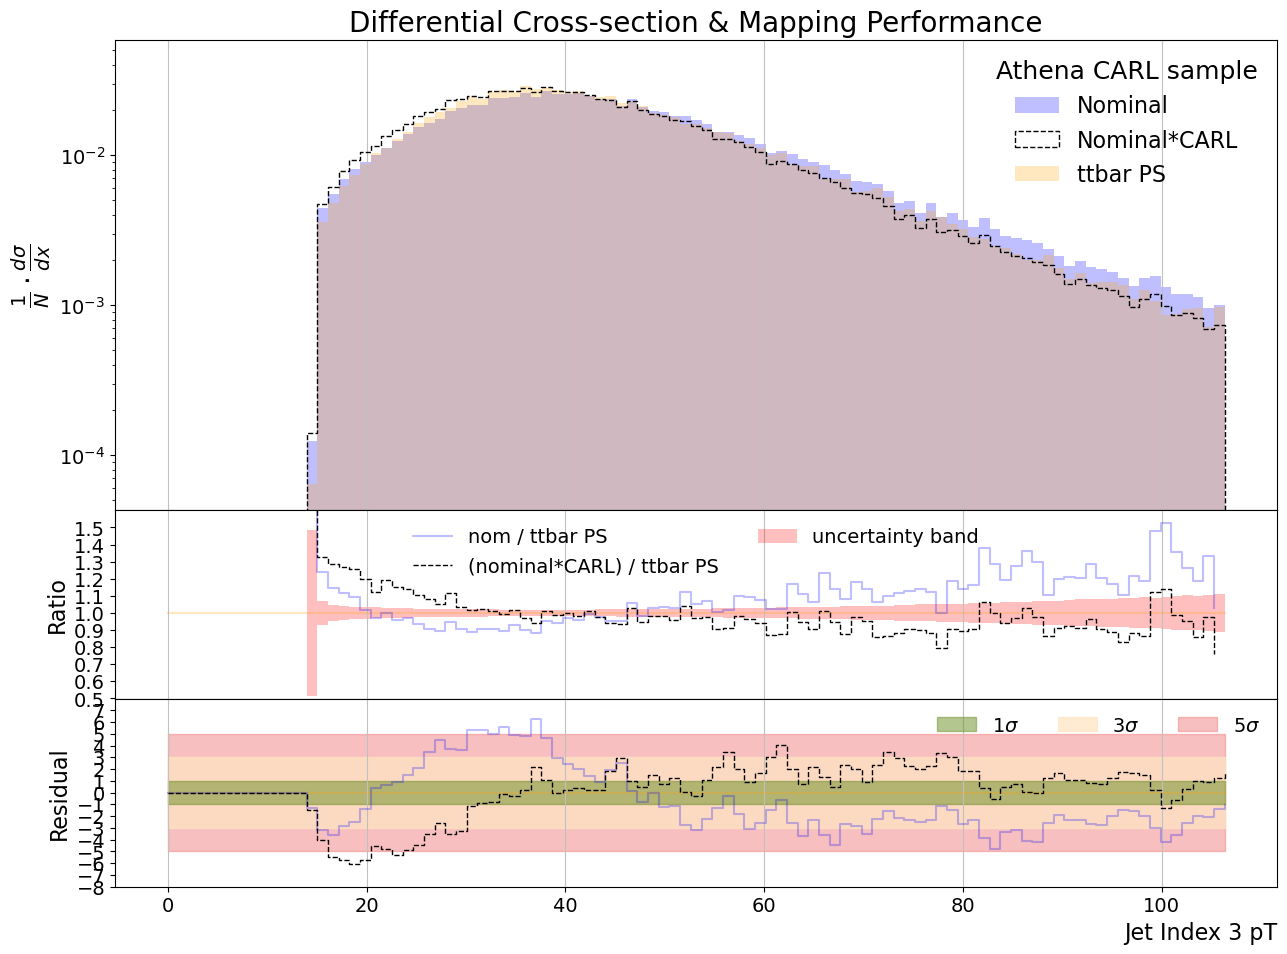

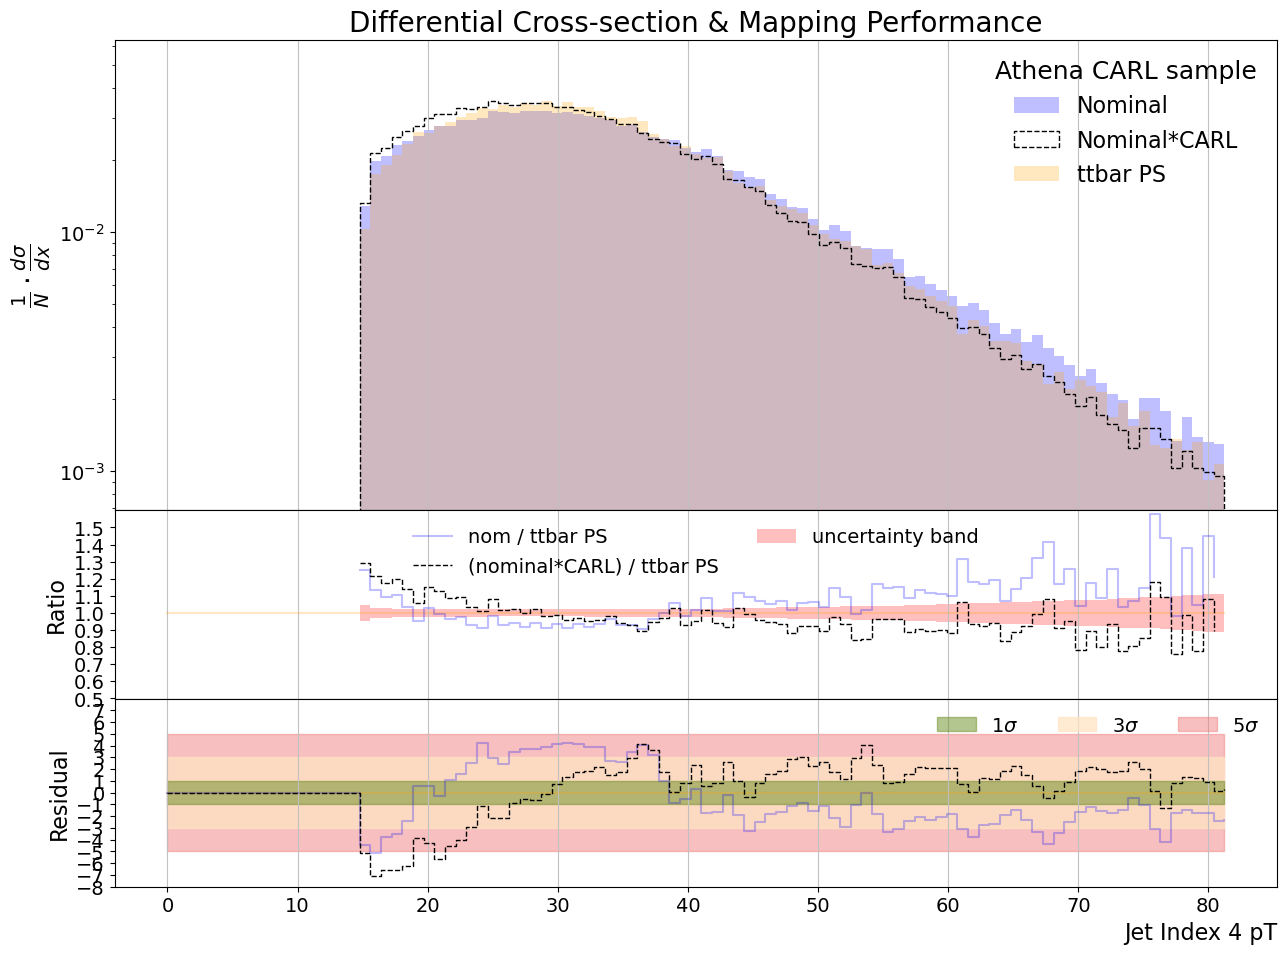

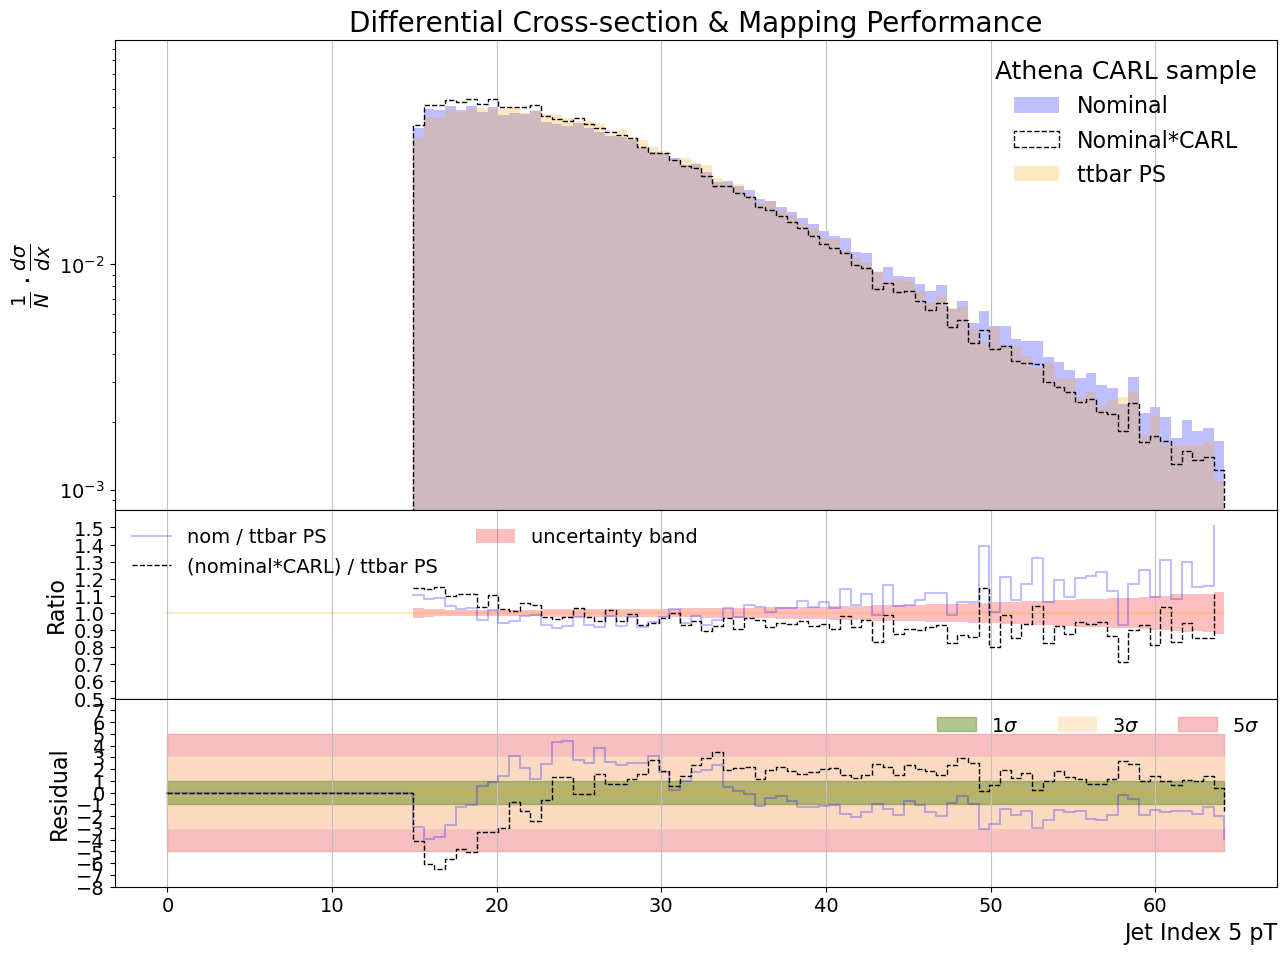

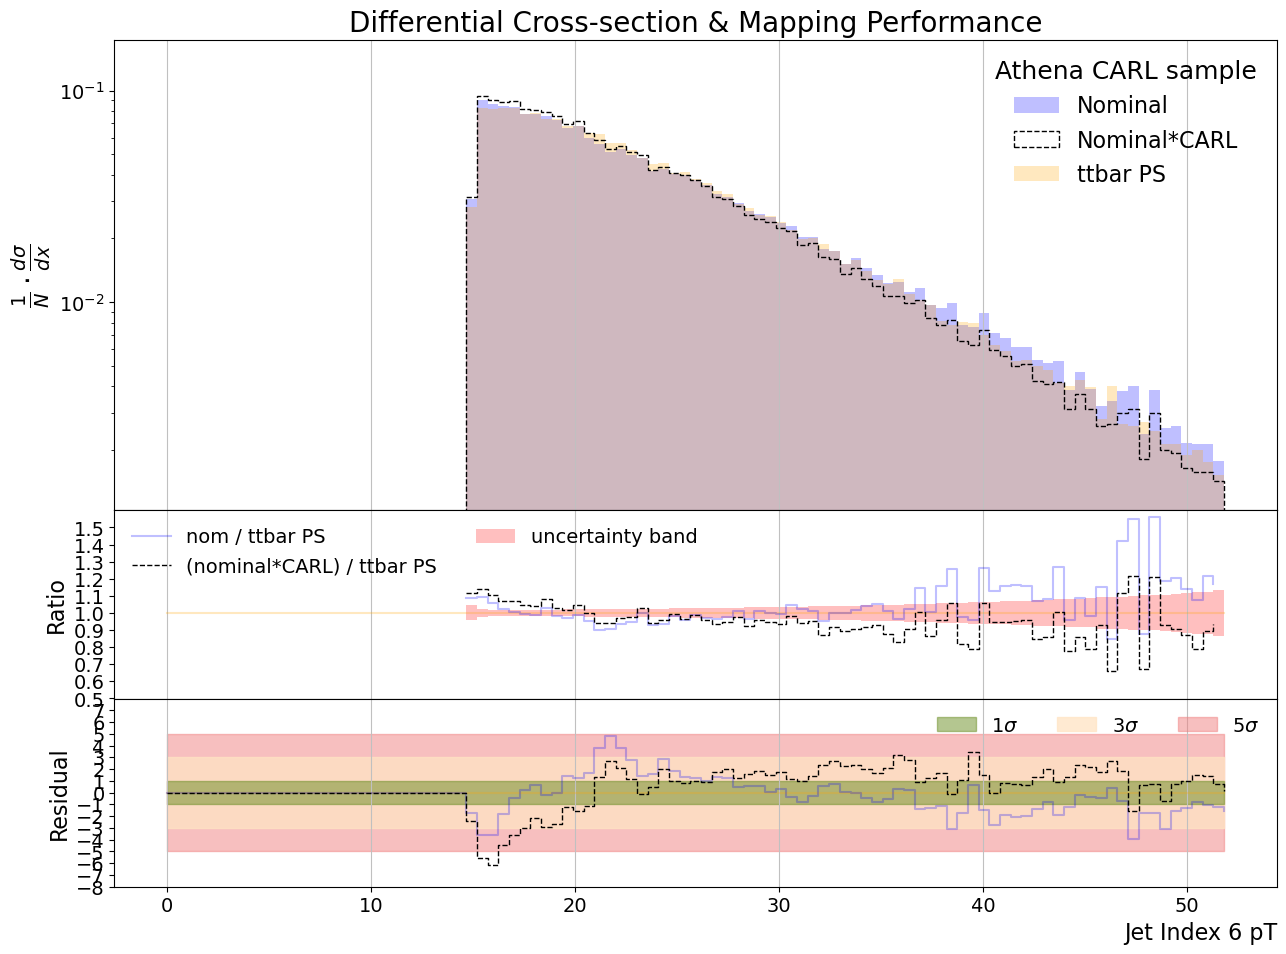

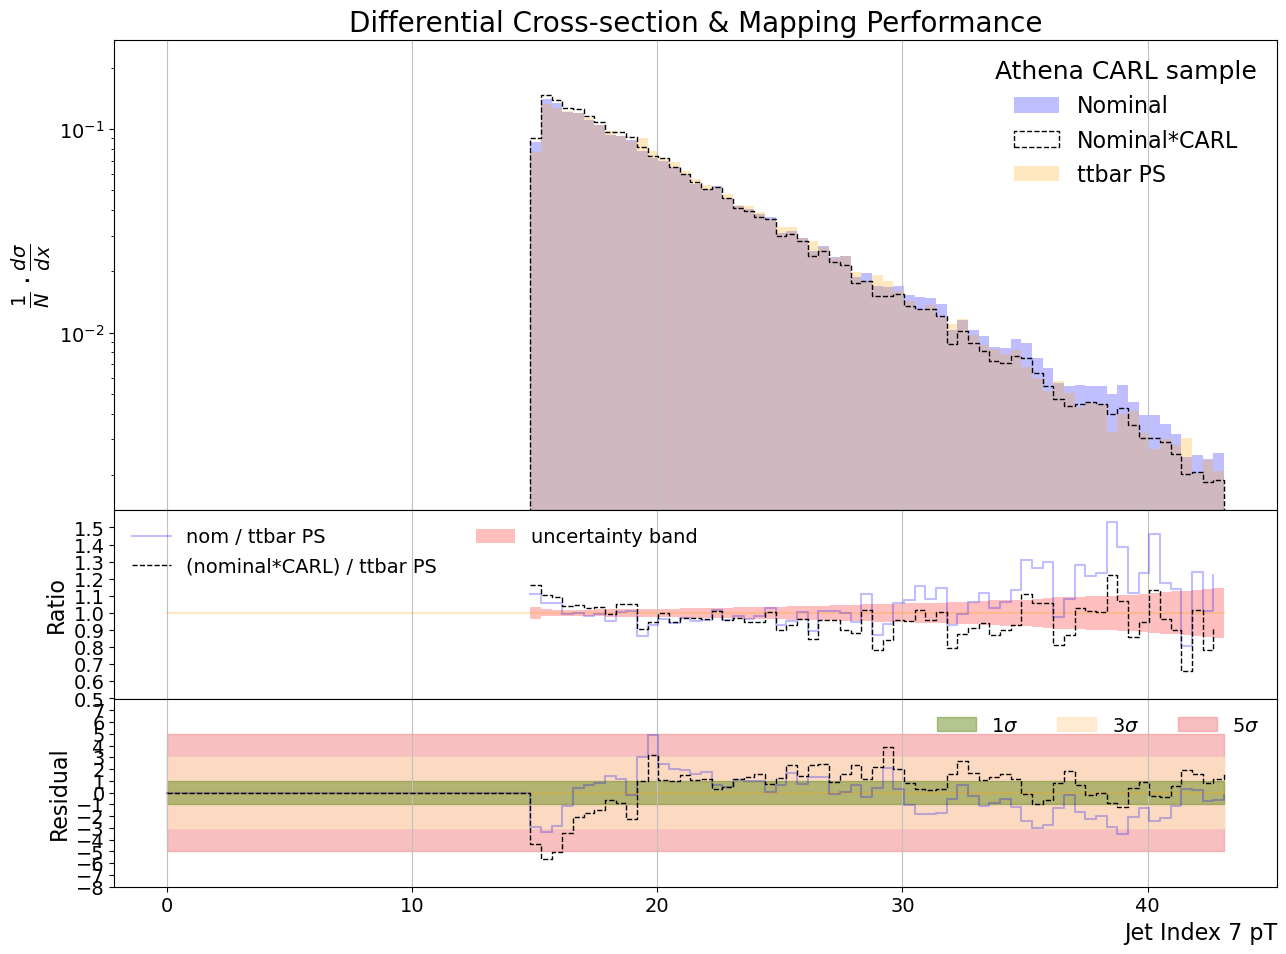

In [34]:
from utils.plotting import plot_distributions

for i in range(8):
    test_nominal_jet_pT_loader.collate_fn = lambda batch: jet_pT(batch, i)
    test_PS_var_jet_pT_loader.collate_fn = lambda batch: jet_pT(batch, i)

    test_nominal_jet_pT = get_plot_data(test_nominal_jet_pT_loader)
    test_PS_var_jet_pT = get_plot_data(test_PS_var_jet_pT_loader)

    plot_distributions(test_nominal_jet_pT[0], test_PS_var_jet_pT[0],
                       test_nominal_jet_pT[1], r_hats, test_PS_var_jet_pT[1],
                       feature_name="Jet Index {} pT".format(i), alternate_name="ttbar PS",
                       nominal_mask=np.isfinite, alternate_mask=np.isfinite)

## Plot the reweighted distributions using the calibrated weights

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

99995
100000


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

99991
99997


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

99890
99906


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

98961
99252


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

94927
96278


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

84921
88477


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

69114
74867


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

50951
57672


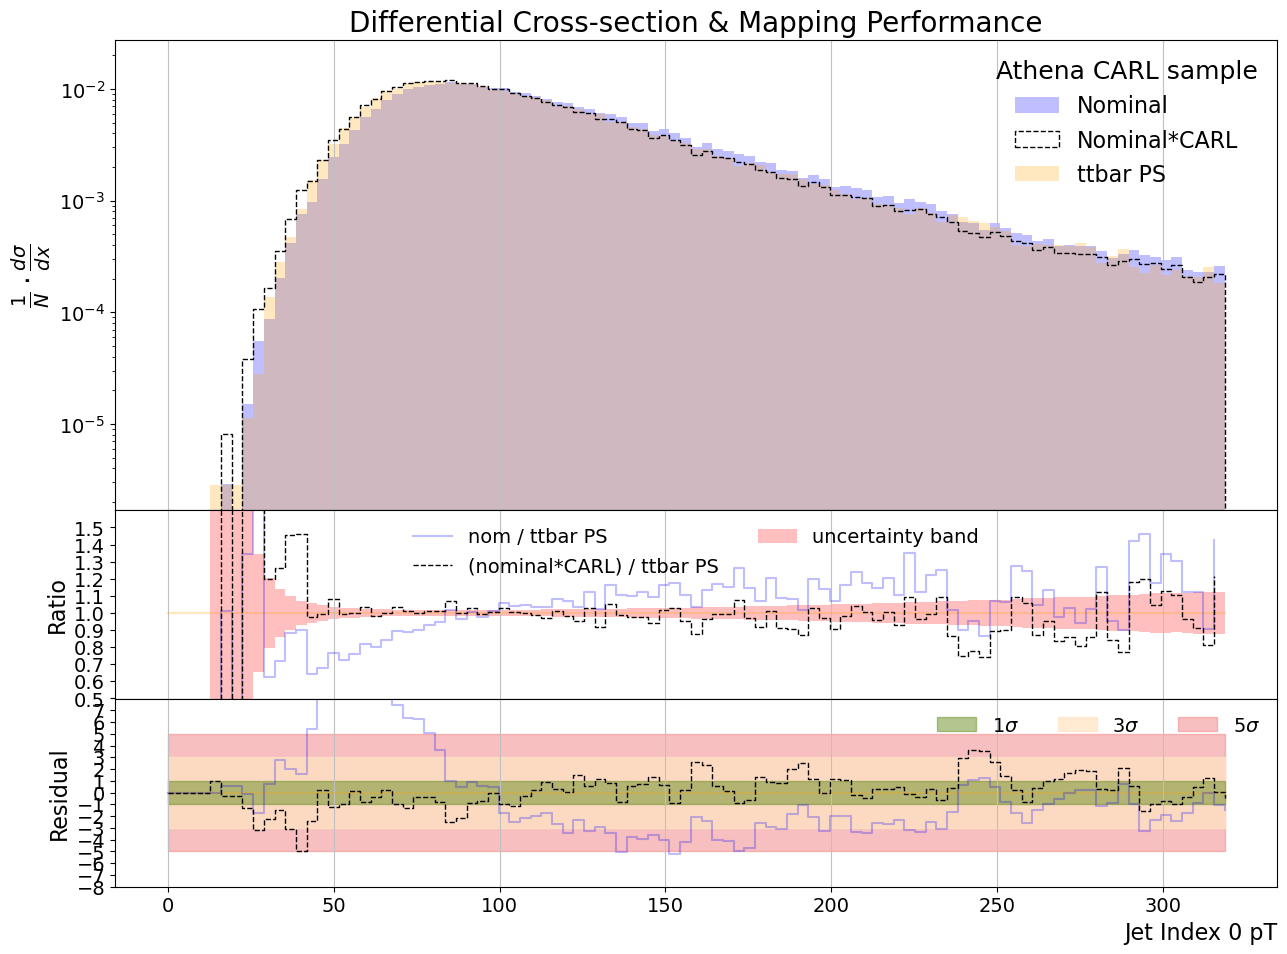

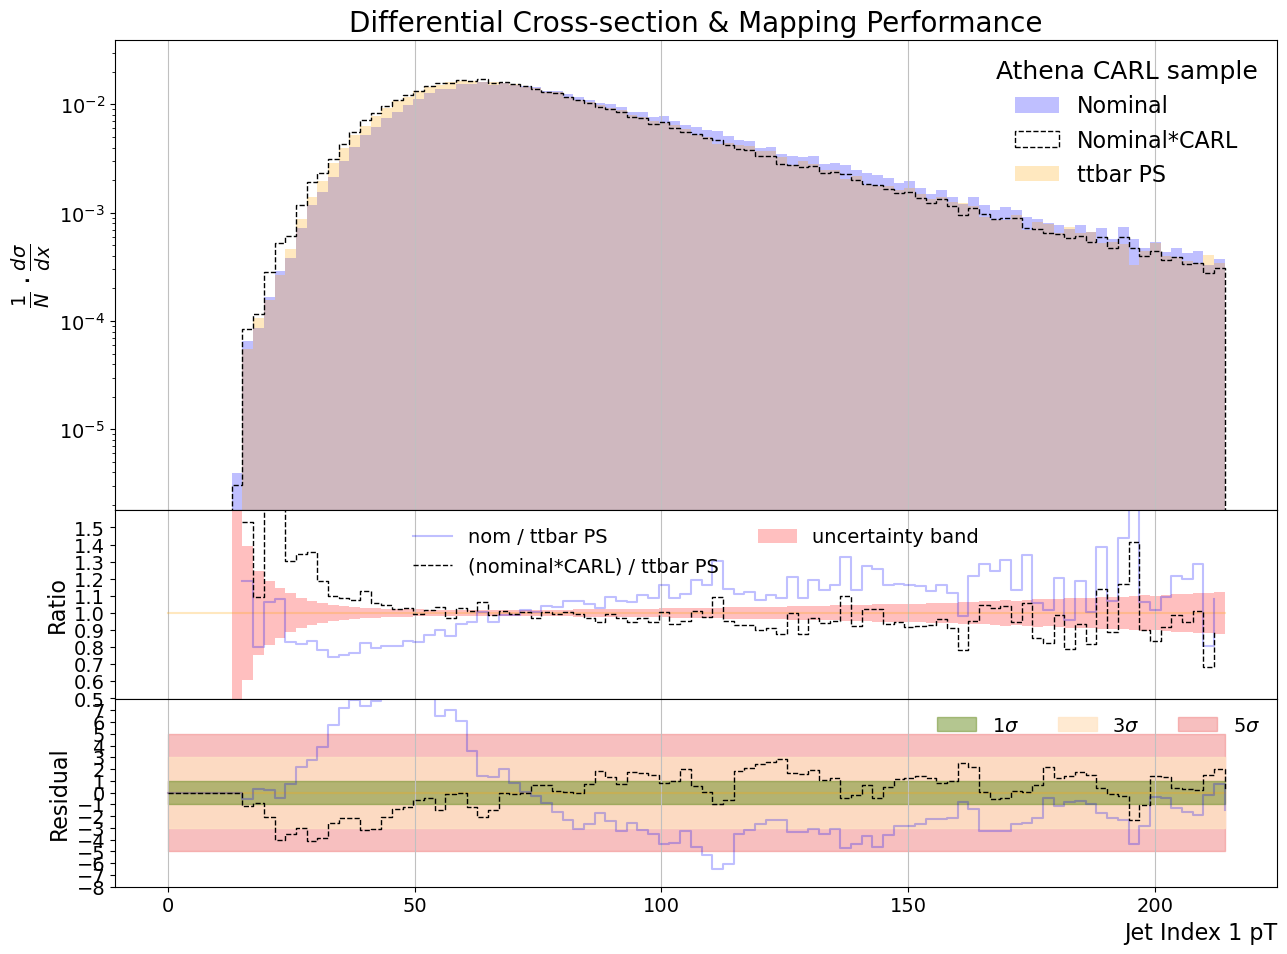

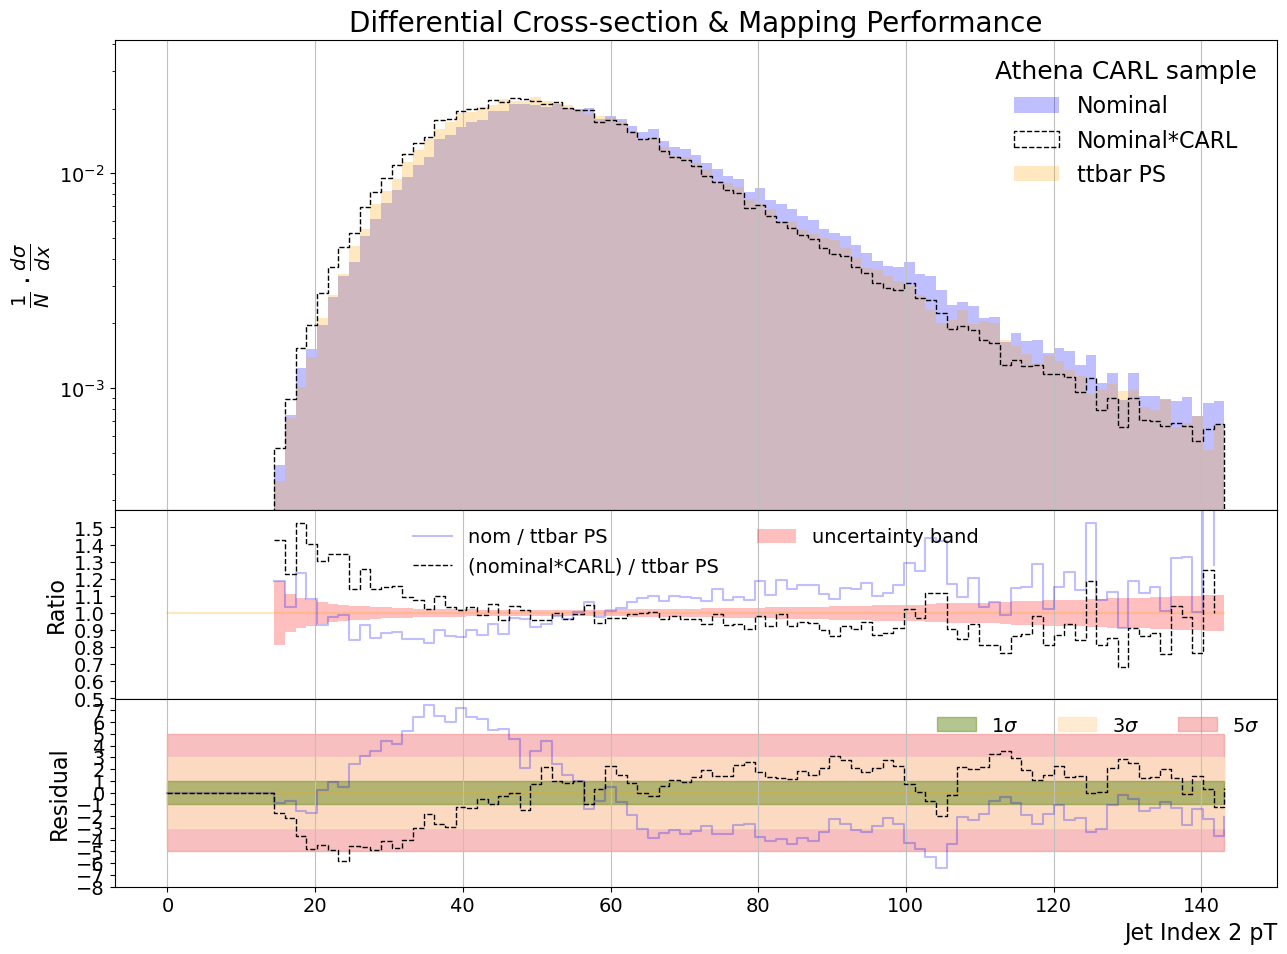

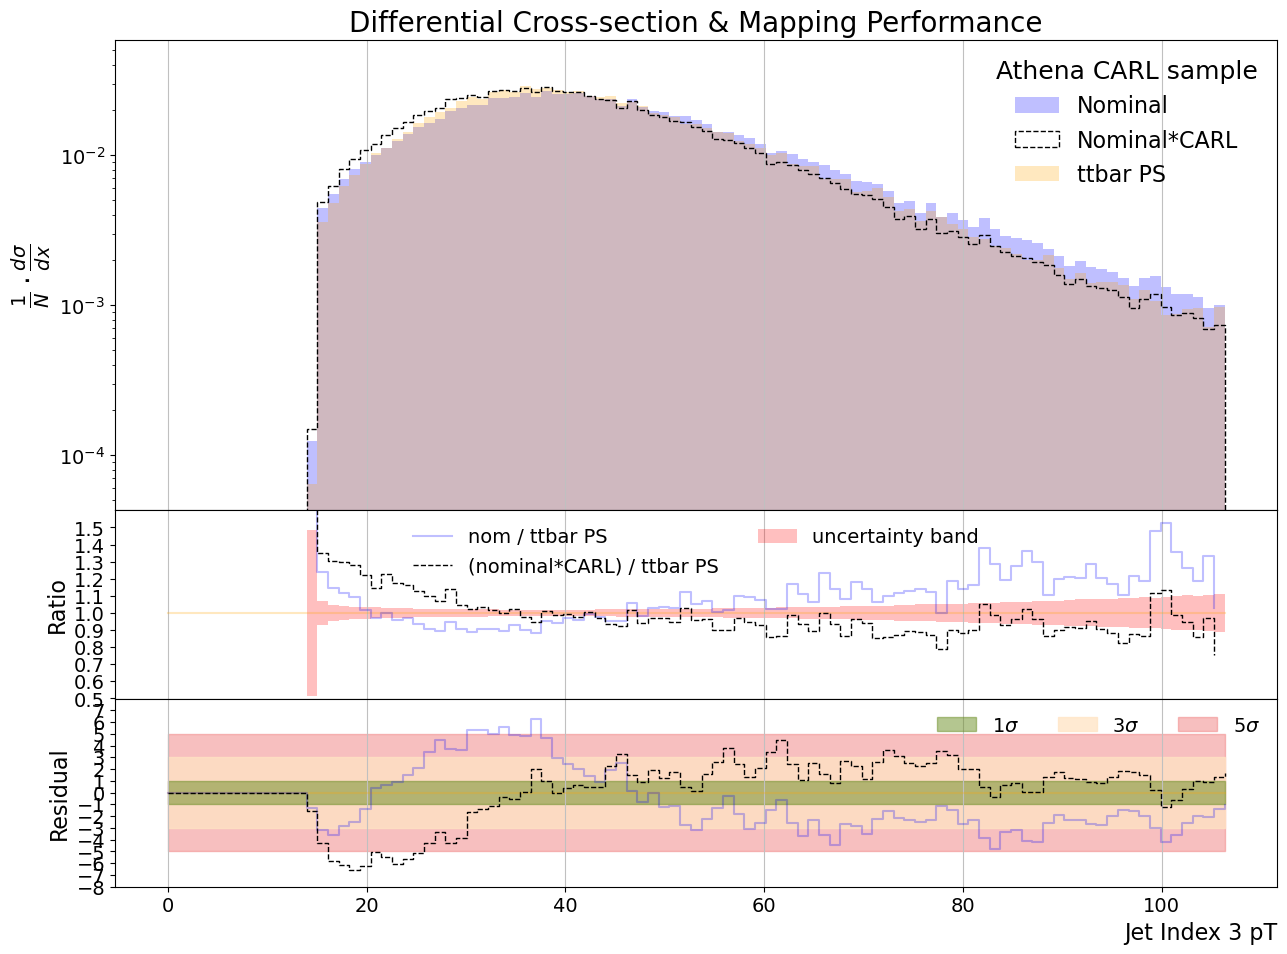

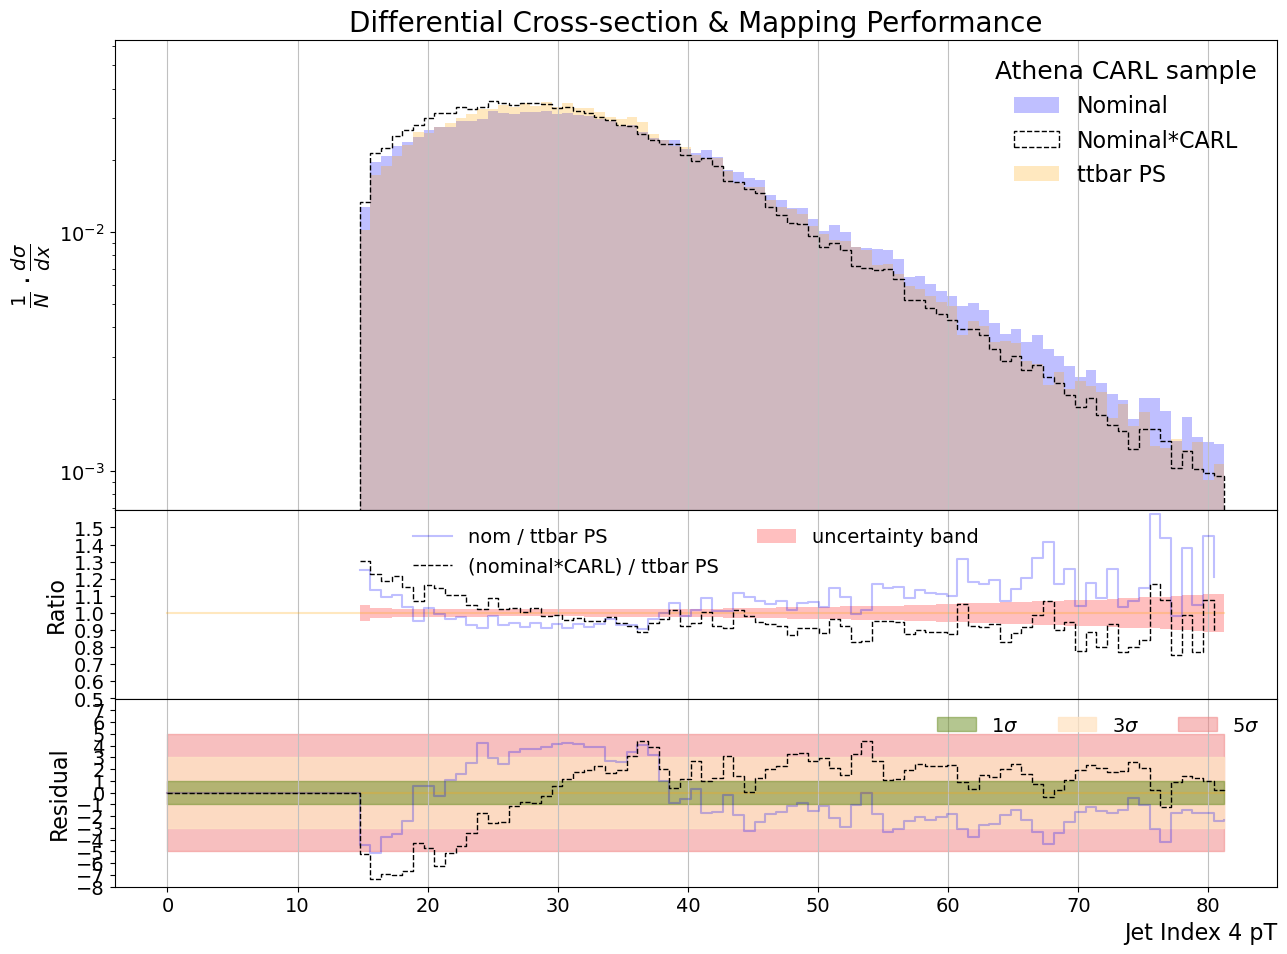

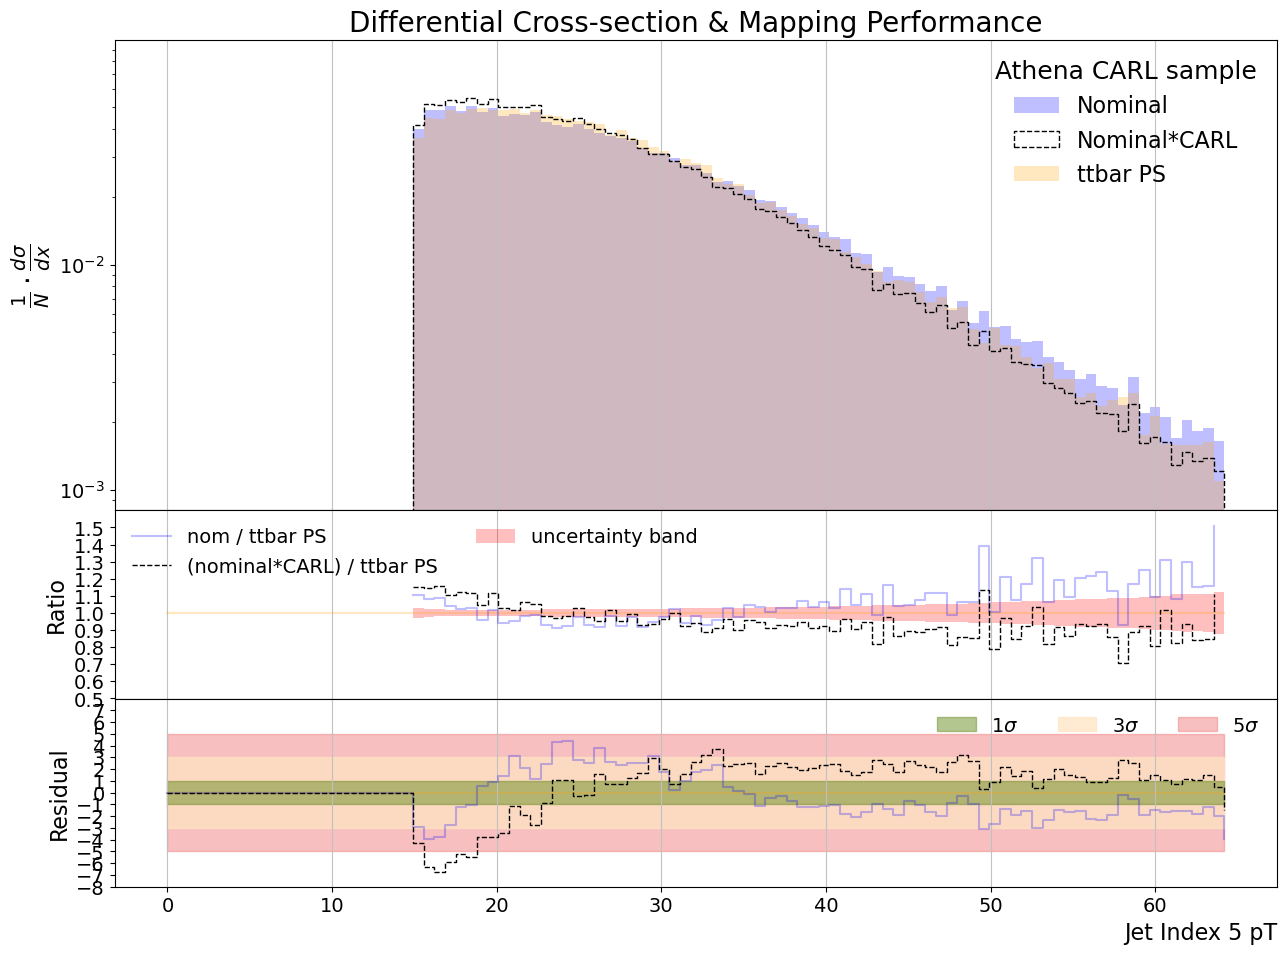

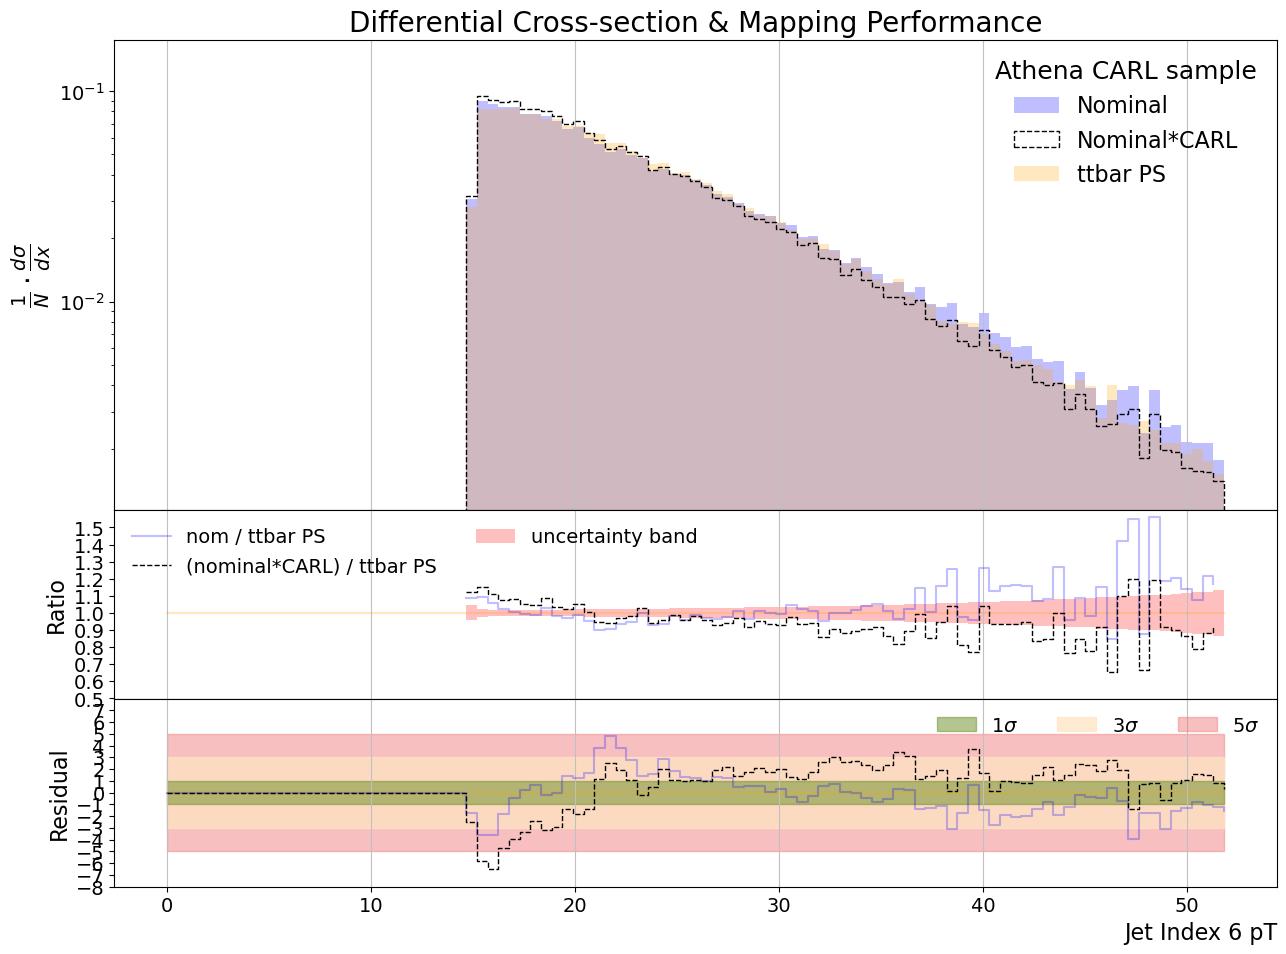

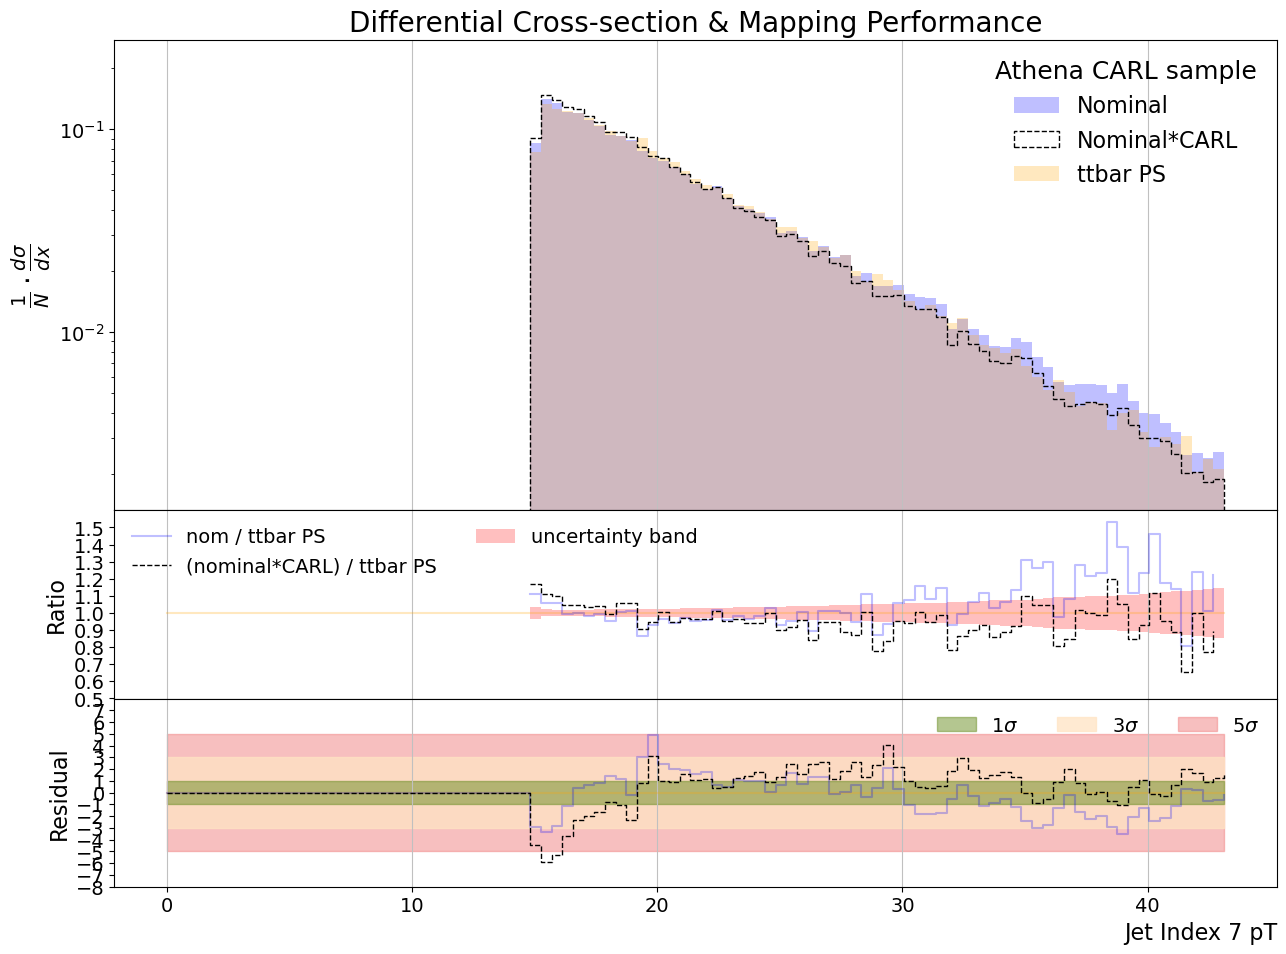

In [35]:
from utils.plotting import plot_distributions

for i in range(8):
    test_nominal_jet_pT_loader.collate_fn = lambda batch: jet_pT(batch, i)
    test_PS_var_jet_pT_loader.collate_fn = lambda batch: jet_pT(batch, i)

    test_nominal_jet_pT = get_plot_data(test_nominal_jet_pT_loader)
    test_PS_var_jet_pT = get_plot_data(test_PS_var_jet_pT_loader)

    plot_distributions(test_nominal_jet_pT[0], test_PS_var_jet_pT[0],
                       test_nominal_jet_pT[1], calibrated_r_hats, test_PS_var_jet_pT[1],
                       feature_name="Jet Index {} pT".format(i), alternate_name="ttbar PS",
                       nominal_mask=np.isfinite, alternate_mask=np.isfinite, carl_mask=np.isfinite)

## Calibration doesn't seem to help in this case